In [1]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import time
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import os
from sklearn.model_selection import train_test_split 
gc.enable()
%matplotlib inline
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

In [2]:
# Seed the unexpected randomness of this world
np.random.seed(123)
#modified from https://www.kaggle.com/gemartin/load-data-reduce-memory-usage, but not changing all the object to catagory here.
def reduce_mem(df):
    """
    modify the data type columns by columns to reduce the memory usage.
    """
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            col_min = df[col].min()
            col_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if col_max < np.iinfo(np.int8).max and col_min > np.iinfo(np.int8).min:
                    df[col] = df[col].astype(np.int8)
                elif col_max < np.iinfo(np.int16).max and col_min > np.iinfo(np.int16).min:
                    df[col] = df[col].astype(np.int16)
                elif col_max < np.iinfo(np.int32).max and col_min > np.iinfo(np.int32).min:
                    df[col] = df[col].astype(np.int32)
                elif col_max < np.iinfo(np.int64).max and col_min > np.iinfo(np.int64).min:
                    df[col] = df[col].astype(np.int64)
            else:
                if col_max < np.finfo(np.float16).max and col_min > np.finfo(np.float16).min:
                    df[col] = df[col].astype(np.float16)
                elif col_max < np.finfo(np.float32).max and col_min > np.finfo(np.float32).min:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    return df

def import_csv(file):
    df = pd.read_csv(file)
    df = reduce_mem(df)
    return df

In [3]:
data=import_csv('data.csv')
data.head(5)

,Unnamed: 0,AMT_ANNUITY_x,AMT_CREDIT_x,AMT_GOODS_PRICE_x,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,...,cc_bal_cc_bal_status__Refused,cc_bal_cc_bal_status__Sent proposal,cc_bal_cc_bal_status__Signed,ip_SK_ID_PREV,ip_NUM_INSTALMENT_VERSION,ip_NUM_INSTALMENT_NUMBER,ip_DAYS_INSTALMENT,ip_DAYS_ENTRY_PAYMENT,ip_AMT_INSTALMENT,ip_AMT_PAYMENT
0,0,24700.5,406597.5,351000.0,202500.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,19.0,1.052734,10.000000,-295.00,-315.5,11559.247070,11559.247070
1,1,35698.5,1293502.5,1129500.0,270000.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,25.0,1.040039,5.078125,-1378.00,-1385.0,64754.585938,64754.585938
2,2,6750.0,135000.0,135000.0,67500.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,3.0,1.333008,2.000000,-754.00,-761.5,7096.154785,7096.154785
3,3,29686.5,312682.5,297000.0,135000.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,16.0,1.125000,4.437500,-252.25,-271.5,62947.085938,62947.085938
4,4,21865.5,513000.0,513000.0,121500.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,66.0,1.166992,7.046875,-1029.00,-1032.0,12666.444336,12214.060547


## using median to replace missing data

In [4]:
data2 = data.drop(['Unnamed: 0','TARGET','is_train'], axis = 1) # delete the first columns (Unnamed: 0'),'TARGET'(NA is to predict),'is_train' 
data3 = data[['TARGET','is_train']]
data4 = data2.fillna(data2.median())  # replace NA using median od each column  

In [5]:
sum(data4.shape[0] - data4.count()) # make sure data does not contain NA 

0

In [6]:
result = pd.merge(data4,data3,how='outer',left_index=True, right_index=True)
sample = result.sample(n = 10000)
sample.head(5)

,AMT_ANNUITY_x,AMT_CREDIT_x,AMT_GOODS_PRICE_x,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,...,cc_bal_cc_bal_status__Signed,ip_SK_ID_PREV,ip_NUM_INSTALMENT_VERSION,ip_NUM_INSTALMENT_NUMBER,ip_DAYS_INSTALMENT,ip_DAYS_ENTRY_PAYMENT,ip_AMT_INSTALMENT,ip_AMT_PAYMENT,TARGET,is_train
303078,22918.5,315000.0,315000.0,81900.0,0.0,0.0,1.0,0.0,0.0,3.0,...,0.0,34.0,1.058594,5.265625,-748.0,-768.00,11547.050781,10813.753906,0.0,1.0
313268,47169.0,597024.0,540000.0,225000.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,6.0,1.000000,3.500000,-389.0,-405.25,28370.197266,28370.197266,NaN,0.0
134544,9000.0,180000.0,180000.0,121500.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,6.0,1.166992,3.500000,-452.0,-491.75,21259.064453,21259.064453,0.0,1.0
300705,25321.5,254700.0,225000.0,135000.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,17.0,1.058594,9.000000,-363.0,-377.00,16714.751953,16714.751953,0.0,1.0
199573,31261.5,640080.0,450000.0,202500.0,0.0,0.0,10.0,0.0,0.0,1.0,...,0.0,7.0,1.142578,4.000000,-285.0,-293.00,52524.679688,52524.679688,0.0,1.0


In [7]:
sample_train=sample.loc[sample['is_train'] == 1]
sample_test=sample.loc[sample['is_train'] == 0]
data_sample = sample_train.drop(['is_train'], axis = 1)

## selecte importance feature

## using LGB

In [8]:
train_labels = sample_train['TARGET']
train = sample_train.drop(['TARGET','is_train'], axis = 1)
test = sample_test.drop(['TARGET','is_train'], axis = 1)
x_train, x_val, y_train, y_val = train_test_split(train, train_labels, test_size=0.5, random_state=18)

C:\Users\Chan\Anaconda3\lib\site-packages\lightgbm\engine.py:99: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds.
[200]	valid_0's auc: 0.699623
Early stopping, best iteration is:
[222]	valid_0's auc: 0.701606


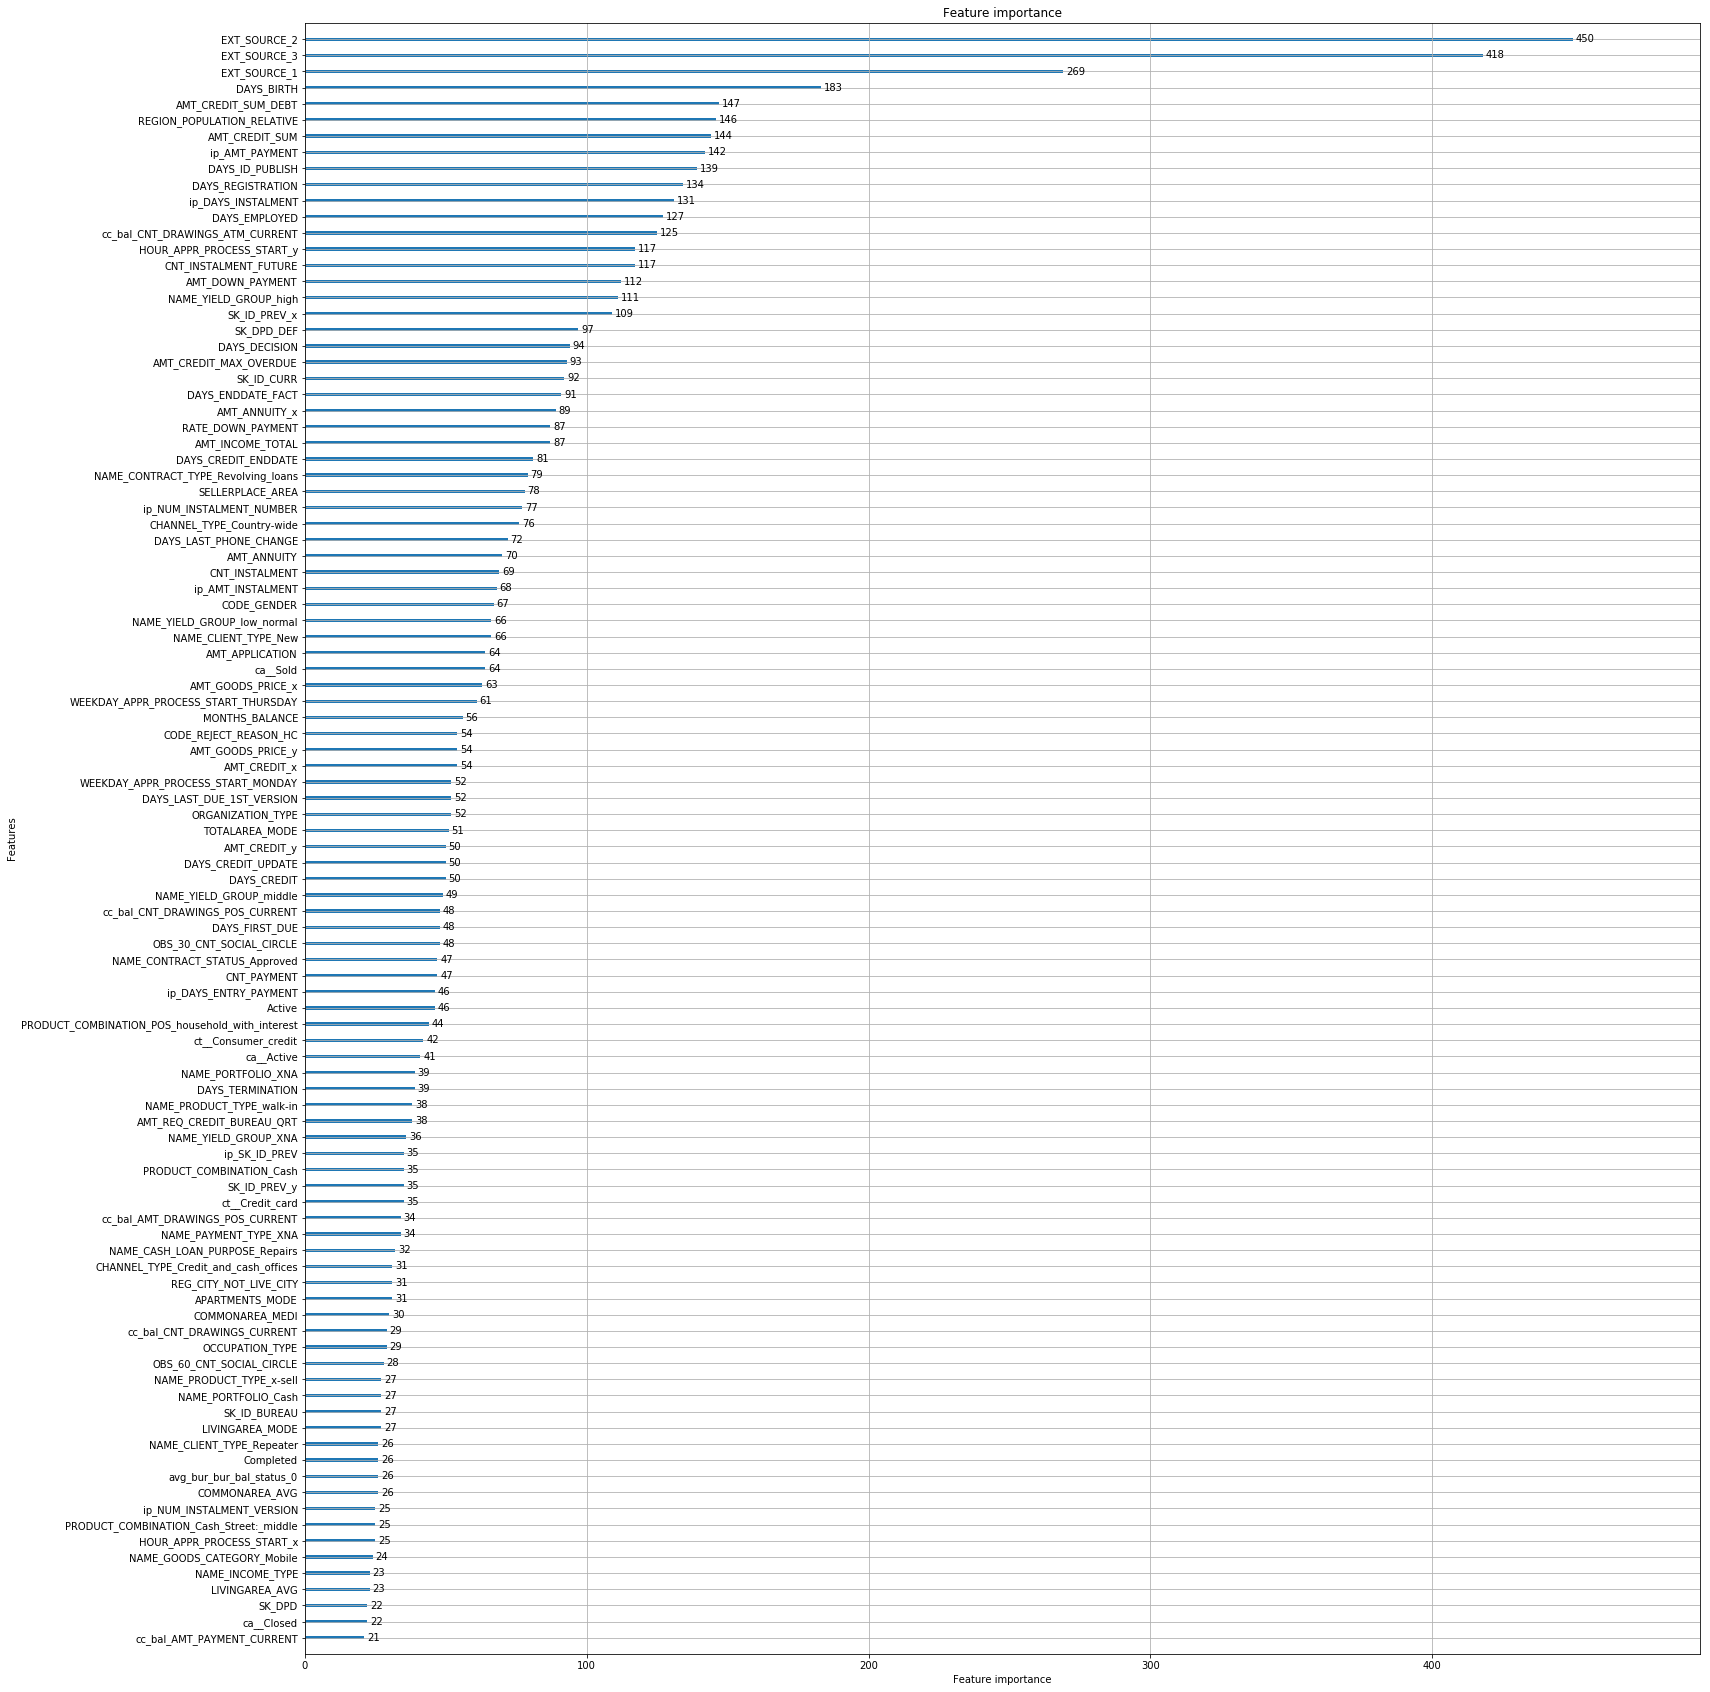

In [9]:
lgb_train = lgb.Dataset(data=x_train, label=y_train)
lgb_eval = lgb.Dataset(data=x_val, label=y_val)
params = {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 
          'learning_rate': 0.01, 'num_leaves': 48, 'num_iteration': 5000, 'verbose': 0 ,
          'colsample_bytree':.8, 'subsample':.9, 'max_depth':7, 'reg_alpha':.1, 'reg_lambda':.1, 
          'min_split_gain':.01, 'min_child_weight':1}
model = lgb.train(params, lgb_train, valid_sets=lgb_eval, early_stopping_rounds=50, verbose_eval=200)
lgb.plot_importance(model, figsize=(25, 30), max_num_features=100)

## using Random Forest

In [10]:
def show_feature_importances(model, features):
    # Dataframe of feature importances sorted from most to least
    results = pd.DataFrame({'feature': features, 'importance': model.feature_importances_})
    results = results.sort_values('importance', ascending = False)
    
    # Display
    print(results.head(10))
    print('\nNumber of features with importance greater than 0.005 = ', np.sum(results['importance'] > 0.005))
    return results

In [11]:
random_forest = RandomForestClassifier(n_estimators = 200, random_state = 50)
random_forest.fit(x_train, y_train)
features = list(train.columns)
feature_importances = show_feature_importances(random_forest, features)

                       feature  importance
37                EXT_SOURCE_2    0.027323
38                EXT_SOURCE_3    0.017375
36                EXT_SOURCE_1    0.012406
379             ip_AMT_PAYMENT    0.010992
378          ip_AMT_INSTALMENT    0.010967
26           DAYS_REGISTRATION    0.010424
22                  DAYS_BIRTH    0.010025
125          DAYS_ENDDATE_FACT    0.009828
111                 SK_ID_CURR    0.009467
188  HOUR_APPR_PROCESS_START_y    0.009249

Number of features with importance greater than 0.005 =  53


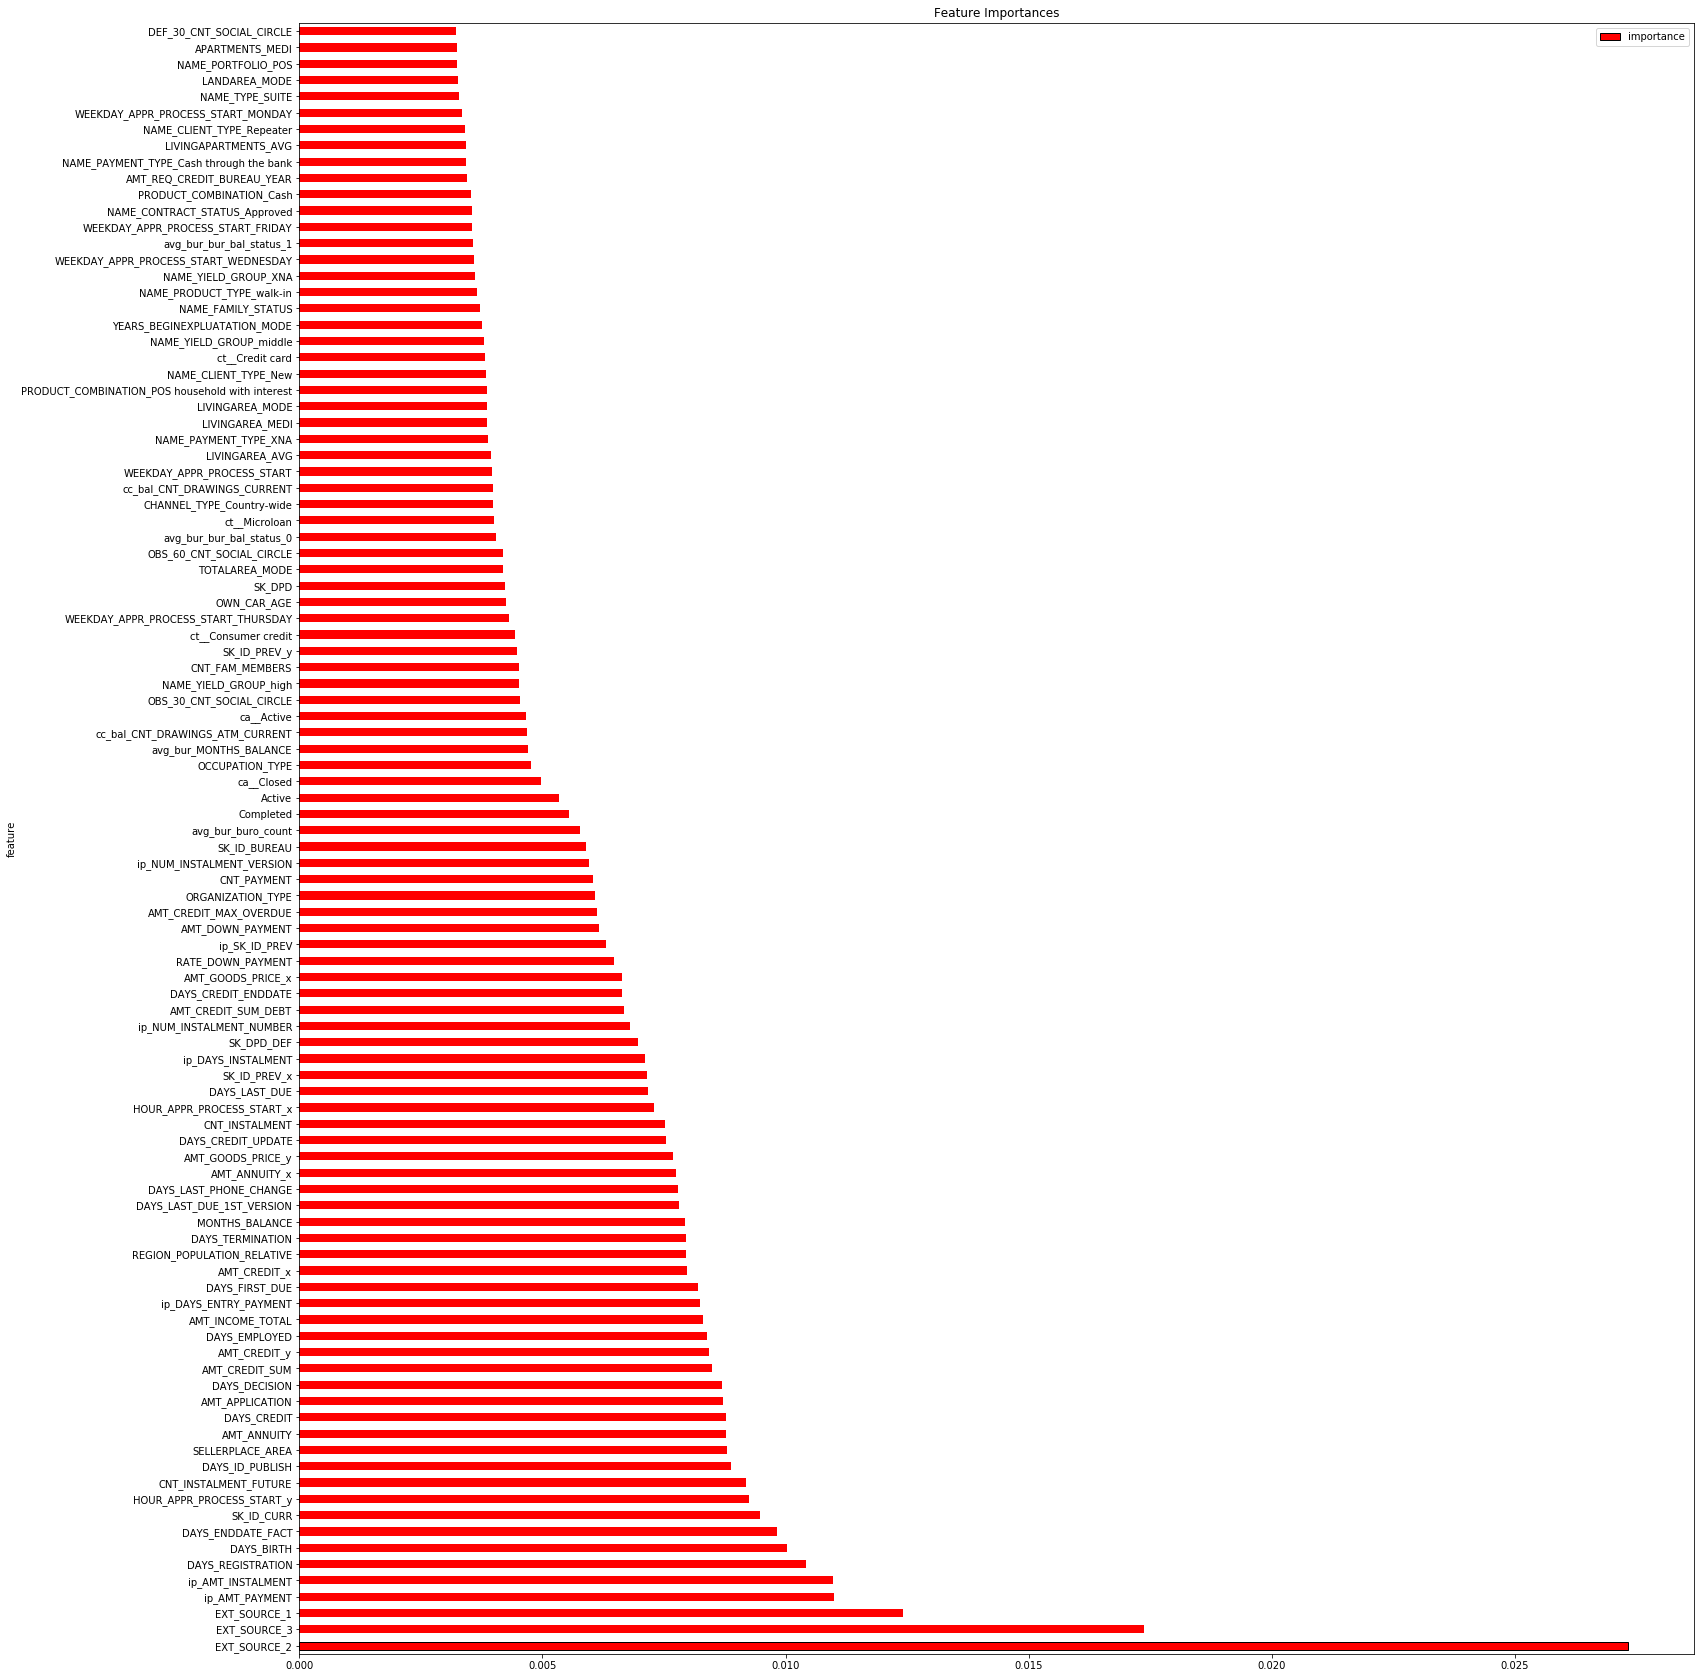

In [12]:
feature_importances.head(100).plot(x = 'feature', y = 'importance', figsize=(25, 30), kind = 'barh',
                     color = 'red', edgecolor = 'k', title = 'Feature Importances')

## using importances fitted over noise

In [13]:
def run_kfold_on_sets(data, shuffle, seed=None):
    # Prepare k-fold, no seed
    folds = KFold(n_splits=4, shuffle=True, random_state=None)
    fold_idx = [(trn_idx, val_idx) for trn_idx, val_idx in folds.split(data)]
    # Gather real features
    train_features = [f for f in data if f not in ['TARGET', 'SK_ID_CURR']]
    # Go over fold and keep track of CV score (train and valid) and feature importances
    imp_df = pd.DataFrame()
    trn_scores = []
    val_scores = []
    for n_fold, (trn_idx, val_idx) in enumerate(fold_idx):
        # split the data
        trn_x, trn_y = data[train_features].iloc[trn_idx], data['TARGET'].iloc[trn_idx]
        val_x, val_y = data[train_features].iloc[val_idx], data['TARGET'].iloc[val_idx]
        # Shuffle the target if required
        if shuffle:
            # Here you could as well use a binomial distribution
            full_y = pd.concat([trn_y, val_y], axis=0).values
            np.random.shuffle(full_y)
            trn_y = pd.Series(full_y[:len(trn_y)])
            val_y = pd.Series(full_y[-len(val_y):])
        
        # Fit LightGBM in RF mode, yes it's quicker than sklearn RandomForest
        clf = LGBMClassifier(
            boosting_type='rf',
            subsample=0.623,
            colsample_bytree=.5,
            num_leaves=127,
            max_depth=8,
            n_estimators=200, 
            random_state=seed,
            verbose=-1,
            silent=True,
            n_jobs=4
        )
        # Fit the model
        clf.fit(trn_x.values, trn_y.values)
        # Get feature importances
        fold_df = pd.DataFrame()
        fold_df["feature"] = list(trn_x.columns)
        fold_df["importance"] = clf.feature_importances_
        fold_df["fold"] = n_fold + 1
        imp_df = pd.concat([imp_df, fold_df], axis=0)
        val_scores.append(roc_auc_score(val_y, clf.predict_proba(val_x.values)[:, 1]))
        trn_scores.append(roc_auc_score(trn_y, clf.predict_proba(trn_x.values)[:, 1]))
        
        del trn_x, trn_y, val_x, val_y, clf
        gc.collect()
    # Keep track of the mean scores
    imp_df['trn_score'] = np.mean(trn_scores)
    imp_df['trn_std'] = np.std(trn_scores)
    imp_df['val_score'] = np.mean(val_scores)
    imp_df['val_std'] = np.std(val_scores)
    
    return imp_df

In [14]:
# Get the actual importance, i.e. without shuffling
actual_imp_df = pd.DataFrame()
nb_runs = 25
start = time.time()
dsp = ''
for i in range(nb_runs):
    # Get current run importances
    imp_df = run_kfold_on_sets(data=data_sample, shuffle=False)
    imp_df['run'] = i + 1
    # Concat the latest importances with the old ones 
    actual_imp_df = pd.concat([actual_imp_df, imp_df], axis=0)
    # Erase previous message
    for l in range(len(dsp)):
        print('\b', end='', flush=True)
    # Display current run and time used
    spent = (time.time() - start) / 60
    dsp = 'Done with %4d of %4d (Spent %5.1f min)' % (i + 1, nb_runs, spent)
    print(dsp, end='', flush=True)

Done with   25 of   25 (Spent   2.9 min)

In [15]:
null_imp_df = pd.DataFrame()
nb_runs = 25
import time
start = time.time()
dsp = ''
for i in range(nb_runs):
    # Get current run importances
    imp_df = run_kfold_on_sets(data=sample_train, shuffle=True)
    imp_df['run'] = i + 1 
    # Concat the latest importances with the old ones
    null_imp_df = pd.concat([null_imp_df, imp_df], axis=0)
    # Erase previous message
    for l in range(len(dsp)):
        print('\b', end='', flush=True)
    # Display current run and time used
    spent = (time.time() - start) / 60
    dsp = 'Done with %4d of %4d (Spent %5.1f min)' % (i + 1, nb_runs, spent)
    print(dsp, end='', flush=True)

Done with   25 of   25 (Spent   2.4 min)

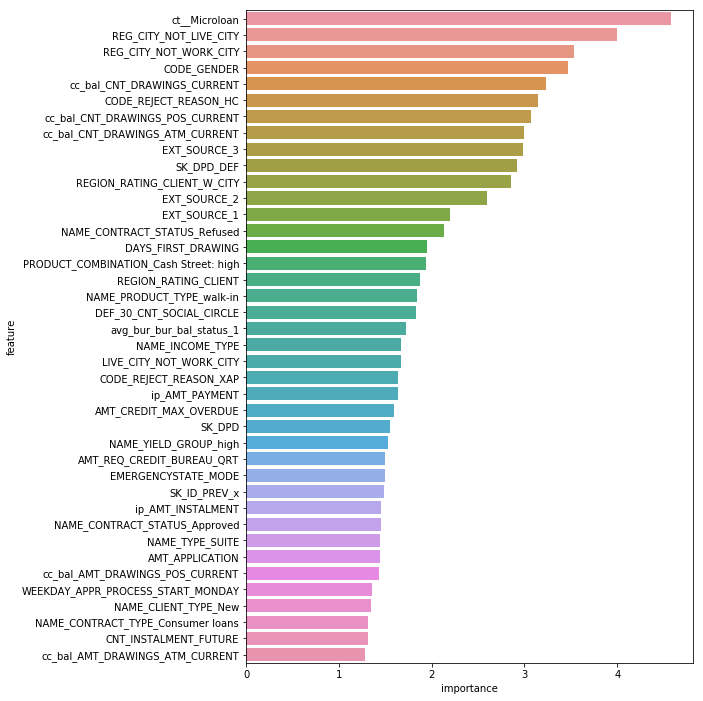

In [17]:
feature_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance'].values
    score = np.percentile(f_act_imps, 25) / (1 + np.percentile(f_null_imps, 75))  # Avoid didvide by zero
    feature_scores.append((_f, score))

scores_df = pd.DataFrame(feature_scores, columns=['feature', 'importance'])

plt.figure(figsize=(8, 12))
sns.barplot(x='importance', y='feature', data=scores_df.sort_values('importance', ascending=False).iloc[0:40])

In [18]:
null_imp_df.to_csv('null_importances_distribution_rf.csv')
actual_imp_df.to_csv('actual_importances_ditribution_rf.csv')

Text(0.5,1,'Inverse probability of .25 percentile wrt to Null Distribution')

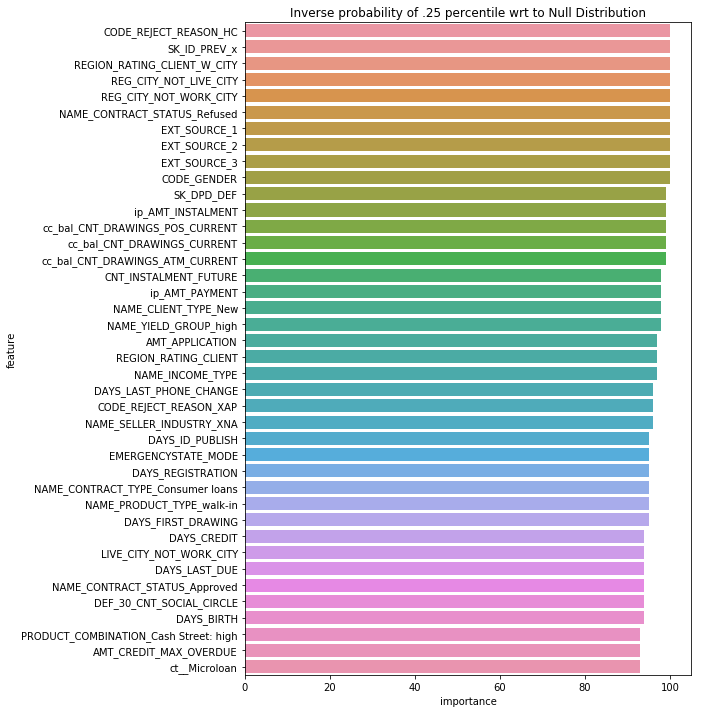

In [19]:
# check the impact of removing uncorrelated feature
correlation_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance'].values
    score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
    correlation_scores.append((_f, score))

corr_scores_df = pd.DataFrame(correlation_scores, columns=['feature', 'importance'])

plt.figure(figsize=(8, 12))
sns.barplot(x='importance', y='feature', data=corr_scores_df.sort_values('importance', ascending=False).iloc[0:40])
plt.title('Inverse probability of .25 percentile wrt to Null Distribution')

In [20]:
#select the features whose importance are not 0
feature_all=corr_scores_df.sort_values('importance', ascending=False)
feature_selected=feature_all[(-feature_all['importance'].isin([0]))] 
m=feature_selected['feature']
h=m.values.tolist()
data5 = sample_train[['TARGET','SK_ID_CURR']]
data6 = sample_train[h]
sample_select = pd.merge(data5,data6,how='outer',left_index=True, right_index=True)
sample_select.head(5)


,TARGET,SK_ID_CURR,CODE_REJECT_REASON_HC,SK_ID_PREV_x,REGION_RATING_CLIENT_W_CITY,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,NAME_CONTRACT_STATUS_Refused,EXT_SOURCE_1,EXT_SOURCE_2,...,LANDAREA_MODE,YEARS_BUILD_AVG,LIVINGAPARTMENTS_MEDI,LIVINGAPARTMENTS_MODE,YEARS_BUILD_MEDI,COMMONAREA_MEDI,NONLIVINGAREA_MEDI,YEARS_BEGINEXPLUATATION_AVG,PRODUCT_COMBINATION_POS household without interest,ELEVATORS_AVG
303078,0.0,451136,0.199951,37.0,2,0,0,0.199951,0.704102,0.151733,...,0.045898,0.755371,0.077026,0.077087,0.758301,0.020996,0.003099,0.981445,0.0,0.000000
134544,0.0,256057,0.000000,8.0,1,0,0,0.000000,0.307861,0.678711,...,0.000000,0.843750,0.450684,0.483887,0.845703,0.286621,0.106384,0.988770,0.0,0.640137
300705,0.0,448378,0.000000,19.0,3,1,1,0.000000,0.506348,0.684082,...,0.045898,0.755371,0.077026,0.077087,0.758301,0.020996,0.003099,0.981445,0.0,0.000000
199573,0.0,331367,0.000000,8.0,1,0,0,0.000000,0.517090,0.644043,...,0.000000,0.918457,0.333496,0.358154,0.919434,0.167114,0.013496,0.994141,0.0,0.560059
238651,0.0,376415,0.000000,24.0,2,0,0,0.000000,0.518066,0.491455,...,0.045898,0.755371,0.077026,0.077087,0.758301,0.020996,0.003099,0.981445,0.0,0.000000


From above, we can find that the most important features are 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'. Then, we want to analyse those features' relationship with our TARGET y.

## effect of age

In [21]:
# Find the correlation of the positive days since birth and target
sample_select['DAYS_BIRTH'] = abs(sample_select['DAYS_BIRTH'])
sample_select['DAYS_BIRTH'].corr(sample_select['TARGET'])

-0.079117248901325946

As the client gets older, there is a negative linear relationship with the target meaning that as clients get older, they tend to repay their loans on time more often. Then, we can make a histogram of the age

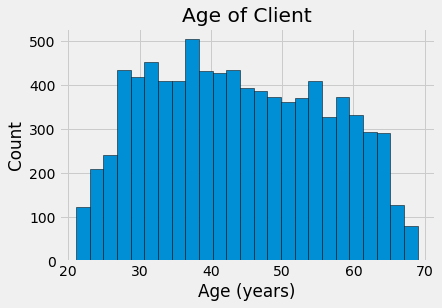

In [22]:
# matplotlib and seaborn for plotting
# Set the style of plots
plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years
plt.hist(sample_select['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

The distribution of age tells us that there are no outliers as all the ages are reasonable. To visualize the effect of the age on the target, we will next make a kernel density estimation plot (KDE) colored by the value of the target. 

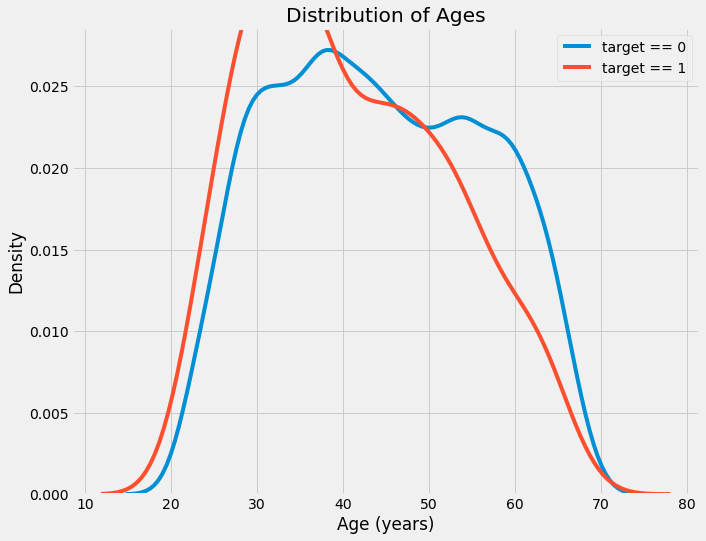

In [23]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(sample_select.loc[sample_select['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(sample_select.loc[sample_select['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

The target == 1 curve skews towards the younger end of the range. Although this is not a significant correlation (-0.0821317970083681 correlation coefficient), this variable is likely going to be useful in a machine learning model because it does affect the target.

## Exterior Sources

The 3 variables with the strongest correlations with the target are EXT_SOURCE_1, EXT_SOURCE_2, and EXT_SOURCE_3. According to the documentation, these features represent a "normalized score from external data source". 
First, we can show the correlations of the EXT_SOURCE features with the target and with each other.

In [24]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = sample_select[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.097027,-0.162091,-0.151042,-0.079117
EXT_SOURCE_1,-0.097027,1.000000,0.115654,0.101019,0.369246
EXT_SOURCE_2,-0.162091,0.115654,1.000000,0.092010,0.084949
EXT_SOURCE_3,-0.151042,0.101019,0.092010,1.000000,0.192465
DAYS_BIRTH,-0.079117,0.369246,0.084949,0.192465,1.000000


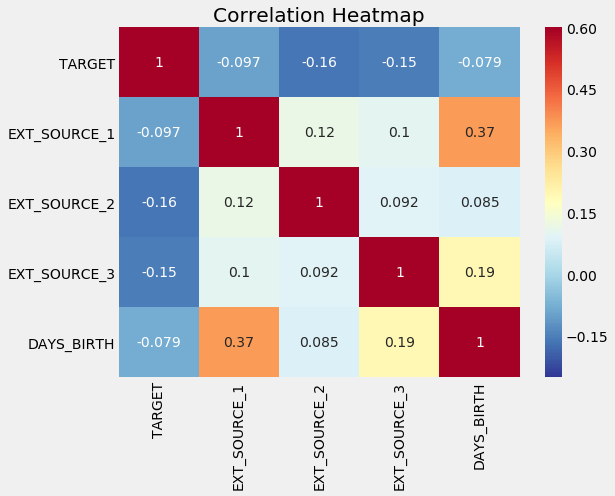

In [25]:
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

All three EXT_SOURCE features have negative correlations with the target, indicating that as the value of the EXT_SOURCE increases, the client is more likely to repay the loan. We can also see that DAYS_BIRTH is positively correlated with EXT_SOURCE_1 indicating that maybe one of the factors in this score is the client age.

Next we can look at the distribution of each of these features colored by the value of the target. This will let us visualize the effect of this variable on the target.

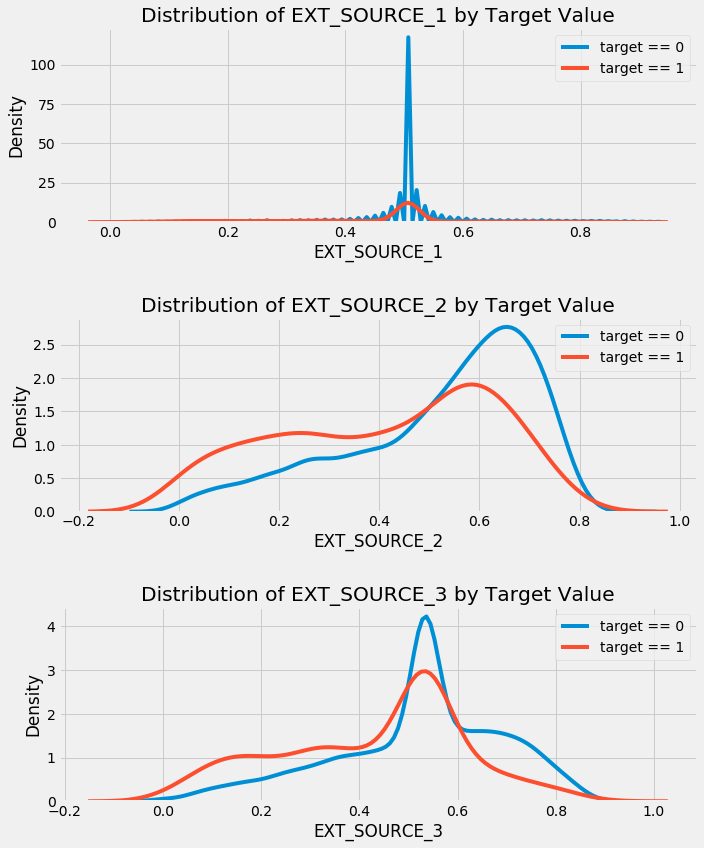

In [26]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(sample_select.loc[sample_select['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(sample_select.loc[sample_select['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

We can clearly see that this feature has some relationship to the likelihood of an applicant to repay a loan. The relationship is not very strong, but these variables will still be useful for a machine learning model to predict whether or not an applicant will repay a loan on time.

## Create Validation Sets 

In [27]:
train_labels =sample_select['TARGET']
train = sample_select.drop(['TARGET'], axis = 1)

In [28]:
test = sample_test.drop(['TARGET','is_train'], axis = 1)

In [29]:
x_train, x_val, y_train, y_val = train_test_split(train, train_labels, test_size=0.2, random_state=18)

## Model Fitting

## Logistic Regression

In [30]:
from sklearn.preprocessing import MinMaxScaler, Imputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

In [31]:
scaler = MinMaxScaler(feature_range = (0, 1))
scaler.fit(x_train)
train_lr = scaler.transform(x_train)
val_lr = scaler.transform(x_val)

In [32]:
print('Train data shape: ', train_lr.shape)
print('validation data shape: ', val_lr.shape)

Train data shape:  (6900, 237)
validation data shape:  (1726, 237)


In [33]:
def lo_reg(C):
    log_reg = LogisticRegression(C = C, class_weight = {0:w,1:1-w})
    scores = cross_val_score(log_reg,train_lr,y_train,cv = 10,scoring = "roc_auc")
    return scores.mean()

In [34]:
start = time.time()
w=list(y_train).count(1)/(list(y_train).count(1)+list(y_train).count(0))
c = 2
criter = [0,0,0]
n_run = 6
for i in range(-1,n_run):
    tem = np.linspace(max(0,c-2**(-i)),c+2**(-i),5)[1:4]
    for j in range(0,3):
        criter[j] = lo_reg(tem[j])
    c = tem[criter == max(criter)][0]
    
    # Erase previous message
    for l in range(len(dsp)):
        print('\b', end='', flush=True)
    # Display current run and time used
    spent = (time.time() - start) / 60
    dsp = 'Done with %4d of %4d (Spent %5.1f min)' % (i + 2, n_run+1, spent)
    print(dsp, end='', flush=True)
log_reg = LogisticRegression(C = c,class_weight={0:w,1:1-w})
logfit=log_reg.fit(train_lr, y_train)
log_reg_pred = log_reg.predict_proba(val_lr)[:, 1]
auc = roc_auc_score(y_val, log_reg_pred)
print("\nC:",c," auc:",auc)

Done with    7 of    7 (Spent   1.3 min)
C: 0.421875  auc: 0.724265644955


In [35]:
log_final=LogisticRegression(C = c)

## Random Forest

In [36]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [37]:
param_test = {'n_estimators':np.linspace(70,110,5,dtype="int"),"min_samples_split":np.linspace(70,110,5,dtype="int")}
gsearch1 = GridSearchCV(estimator = RandomForestClassifier(class_weight={0:w,1:1-w},n_jobs=-1),
                        param_grid = param_test, scoring='roc_auc',n_jobs=-1,iid=False, cv=10)
gsearch1.fit(x_train,y_train)
gsearch1.best_params_, gsearch1.best_score_

({'min_samples_split': 80, 'n_estimators': 100}, 0.72161257330275941)

So that the best parameter is 'min_samples_split'=80, 'n_estimators'= 100. It is not stable.

## Gradient Boosting Classifier

In [38]:
from sklearn.ensemble import GradientBoostingClassifier

In [42]:
param_test = {'n_estimators':range(100,201,10)}
gsearch = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1,
                                                              min_samples_split=90,min_samples_leaf=50,max_depth=8,
                                                              max_features='sqrt',subsample=0.8,random_state=10),
                        param_grid = param_test, scoring='roc_auc',n_jobs=-1,iid=False, cv=10)
gsearch.fit(x_train,y_train)
gsearch.best_params_, gsearch.best_score_

({'n_estimators': 180}, 0.71499829778156809)

The best "n_estimators" is 180, next we will decide the depth and the "min_samples_split"

In [45]:
param_test = {'max_depth':range(5,16,2), 'min_samples_split':range(200,1001,200)}
gsearch = GridSearchCV(estimator = GradientBoostingClassifier(n_estimators = 180,learning_rate=0.1,
                                                              min_samples_leaf=50,max_features='sqrt',
                                                              subsample=0.8,random_state=10),
                        param_grid = param_test, scoring='roc_auc',n_jobs=-1,iid=False, cv=10)
gsearch.fit(x_train,y_train)
gsearch.best_params_, gsearch.best_score_

({'max_depth': 7, 'min_samples_split': 1000}, 0.71822702222899015)

As for max_depth, we just choose 7 as the best choice. As we can see, the best min_samples_split is 1000,which is the boundary of our setting.We still need to boarden our range. We also take the min_samples_leaf into consideration.

In [49]:
param_test = {'min_samples_leaf':range(80,121,10),'min_samples_split':range(1000,1501,100)}
gsearch = GridSearchCV(estimator = GradientBoostingClassifier(n_estimators = 180,learning_rate=0.1,
                                                              max_depth = 7,max_features='sqrt',
                                                              subsample=0.8,random_state=10),
                        param_grid = param_test, scoring='roc_auc',n_jobs=-1,iid=False, cv=10)
gsearch.fit(x_train,y_train)
gsearch.best_params_, gsearch.best_score_

({'min_samples_leaf': 100, 'min_samples_split': 1400}, 0.72897657617999345)

'min_samples_leaf'= 100, 'min_samples_split'= 1400 is the best.

## AdaBoosting

In [59]:
from sklearn.ensemble import AdaBoostClassifier

In [70]:
dt = RandomForestClassifier(n_estimators=100,class_weight={0:w,1:1-w},n_jobs=-1,min_samples_split=80,)
ada = AdaBoostClassifier(base_estimator=dt,learning_rate = 2)
param_test = {'n_estimators': range(100,151,10)}
gsearch = GridSearchCV(ada,param_test,cv=10)
gsearch.fit(x_train,y_train)
gsearch.best_params_, gsearch.best_score_

({'n_estimators': 140}, 0.91333333333333333)

## ROC curve:

In [51]:
from sklearn.metrics import confusion_matrix,accuracy_score,recall_score,roc_auc_score,classification_report,roc_auc_score,roc_curve,auc

#Model function
def plot_model(algorithm,dtrain_X,dtrain_Y,dtest_X,dtest_Y,cols=None):

    algorithm.fit(dtrain_X[cols],dtrain_Y)
    predictions = algorithm.predict(dtest_X[cols])
    print (algorithm)
    
    print ("Accuracy score : ", accuracy_score(predictions,dtest_Y))
    print ("Recall score   : ", recall_score(predictions,dtest_Y))
    print ("classification report :\n",classification_report(predictions,dtest_Y))
    
    fig = plt.figure(figsize=(10,8))
    ax  = fig.add_subplot(111)
    prediction_probabilities = algorithm.predict_proba(dtest_X[cols])[:,1]
    fpr , tpr , thresholds   = roc_curve(dtest_Y,prediction_probabilities)
    ax.plot(fpr,tpr,label   = ["Area under curve : ",auc(fpr,tpr)],linewidth=2,linestyle="dotted")
    ax.plot([0,1],[0,1],linewidth=2,linestyle="dashed")
    plt.legend(loc="best")
    plt.title("ROC-CURVE & AREA UNDER CURVE")
    

In [52]:
w=list(y_train).count(1)/(list(y_train).count(1)+list(y_train).count(0))

In [53]:
log_final=LogisticRegression(C = c,class_weight={0:w,1:1-w})

LogisticRegression(C=0.421875,
          class_weight={0: 0.08521739130434783, 1: 0.9147826086956522},
          dual=False, fit_intercept=True, intercept_scaling=1,
          max_iter=100, multi_class='ovr', n_jobs=1, penalty='l2',
          random_state=None, solver='liblinear', tol=0.0001, verbose=0,
          warm_start=False)
Accuracy score :  0.636152954809
Recall score   :  0.150746268657
classification report :
              precision    recall  f1-score   support

        0.0       0.64      0.94      0.76      1056
        1.0       0.63      0.15      0.24       670

avg / total       0.63      0.64      0.56      1726



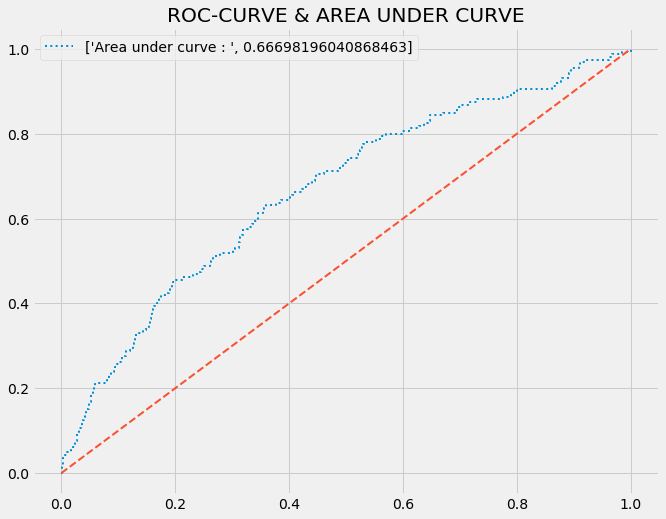

In [54]:
plot_model(log_final,x_train,y_train,x_val,y_val,x_train.columns)

In [55]:
rf = RandomForestClassifier(n_estimators= 90, max_depth=20,class_weight={0:w,1:1-w}, min_samples_split=70,
                                  min_samples_leaf=30,max_features=18 ,oob_score=True, random_state=10,n_jobs=-1)

RandomForestClassifier(bootstrap=True,
            class_weight={0: 0.08521739130434783, 1: 0.9147826086956522},
            criterion='gini', max_depth=20, max_features=18,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=30,
            min_samples_split=70, min_weight_fraction_leaf=0.0,
            n_estimators=90, n_jobs=-1, oob_score=True, random_state=10,
            verbose=0, warm_start=False)
Accuracy score :  0.858632676709
Recall score   :  0.204225352113
classification report :
              precision    recall  f1-score   support

        0.0       0.93      0.92      0.92      1584
        1.0       0.18      0.20      0.19       142

avg / total       0.87      0.86      0.86      1726



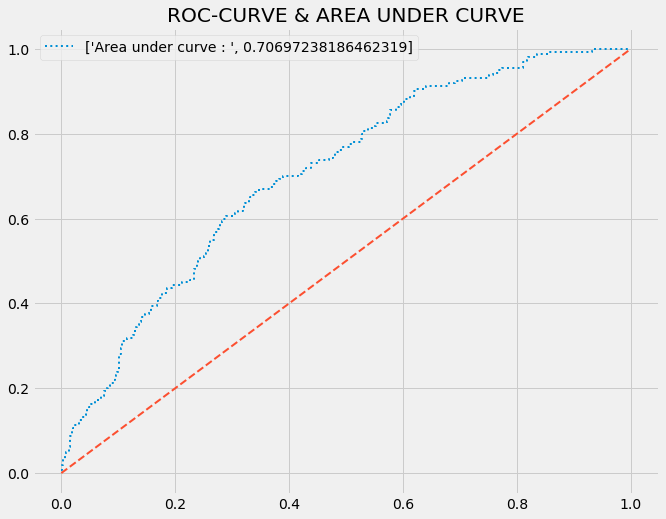

In [56]:
plot_model(rf,x_train,y_train,x_val,y_val,x_train.columns)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=7,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=100, min_samples_split=1400,
              min_weight_fraction_leaf=0.0, n_estimators=180,
              presort='auto', random_state=10, subsample=0.8, verbose=0,
              warm_start=False)
Accuracy score :  0.903244495944
Recall score   :  0.111111111111
classification report :
              precision    recall  f1-score   support

        0.0       0.99      0.91      0.95      1717
        1.0       0.01      0.11      0.01         9

avg / total       0.99      0.90      0.94      1726



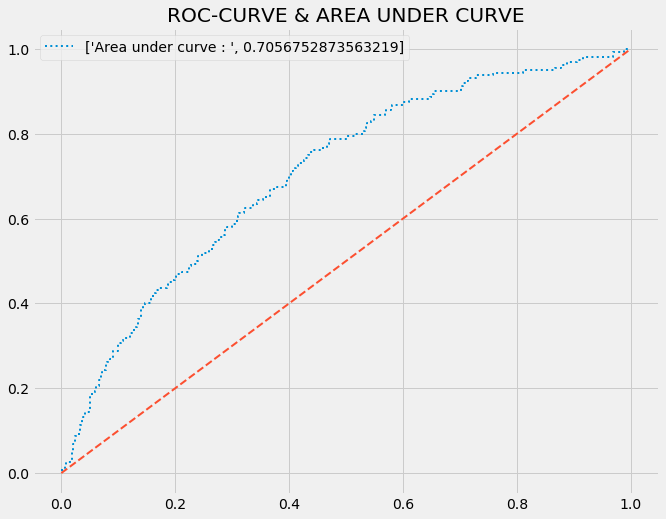

In [58]:
gbc = GradientBoostingClassifier(n_estimators = 180,min_samples_leaf=100,min_samples_split=1400,
                                 learning_rate=0.1,max_depth = 7,max_features='sqrt',subsample=0.8,random_state=10)
plot_model(gbc,x_train,y_train,x_val,y_val,x_train.columns)

In [71]:
dt = RandomForestClassifier(n_estimators=100,class_weight={0:w,1:1-w},n_jobs=-1,min_samples_split=80,)
ada = AdaBoostClassifier(n_estimators=140,base_estimator=dt,learning_rate = 2)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=RandomForestClassifier(bootstrap=True,
            class_weight={0: 0.08521739130434783, 1: 0.9147826086956522},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=80, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False),
          learning_rate=2, n_estimators=140, random_state=None)
Accuracy score :  0.905561993048
Recall score   :  0.2
classification report :
              precision    recall  f1-score   support

        0.0       1.00      0.91      0.95      1721
        1.0       0.01      0.20      0.01         5

avg / total       0.99      0.91      0.95      1726



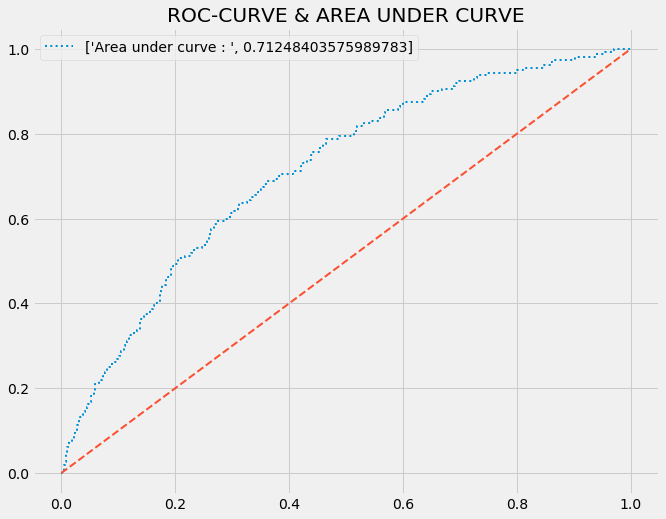

In [72]:
plot_model(ada,x_train,y_train,x_val,y_val,x_train.columns)